In [260]:
from IPython.display import Markdown
import os
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(color_codes=True) 
%matplotlib inline 
from langchain_openai import ChatOpenAI
from langchain_experimental.sql import SQLDatabaseChain
from langchain.sql_database import SQLDatabase
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from chromadb.config import Settings
import fitz
import json
import nltk
from langchain.prompts import PromptTemplate
from langchain.agents import Tool
from langchain.agents import initialize_agent, AgentType

# Setup Environment

In [8]:
def setup_environment():
    import sys
    sys.path.append('C:\\gitworkspace\\aimldemo\\jupyterworkapce')
    import stratup_env_setup
    stratup_env_setup.set_env()

In [9]:
setup_environment()

In [10]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create sales_data DB table in MYSQL DB and Import sales_data csv file

In [11]:
schema_markdown = """```
CREATE TABLE genai.sales_data (
    id INT PRIMARY KEY AUTO_INCREMENT,
    Date DATE NOT NULL,
    Product VARCHAR(50) NOT NULL,
    Region VARCHAR(50) NOT NULL,
    Sales INT NOT NULL,
    Customer_Age INT NOT NULL,
    Customer_Gender VARCHAR(10) CHECK (Customer_Gender IN ('Male', 'Female')),
    Customer_Satisfaction DECIMAL(10,8) NOT NULL
);
```"""

In [12]:
display(Markdown(schema_markdown))

```
CREATE TABLE genai.sales_data (
    id INT PRIMARY KEY AUTO_INCREMENT,
    Date DATE NOT NULL,
    Product VARCHAR(50) NOT NULL,
    Region VARCHAR(50) NOT NULL,
    Sales INT NOT NULL,
    Customer_Age INT NOT NULL,
    Customer_Gender VARCHAR(10) CHECK (Customer_Gender IN ('Male', 'Female')),
    Customer_Satisfaction DECIMAL(10,8) NOT NULL
);
```

In [13]:
# Read database credentials from environment variables
DB_USER = os.getenv('MYSQL_DB_USER')  
DB_PASSWORD = os.getenv('MYSQL_DB_PASSWORD')  
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'genai'

In [14]:
dbengine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [15]:
csv_file_path = "C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\sales_data.csv"
df = pd.read_csv(csv_file_path)

In [16]:
df.head(5)

,id,Date,Product,Region,Sales,Customer_Age,Customer_Gender,Customer_Satisfaction
0,1,1/1/2022,Widget C,South,786,26,Male,2.874407
1,2,1/2/2022,Widget D,East,850,29,Male,3.365205
2,3,1/3/2022,Widget A,North,871,40,Female,4.547364
3,4,1/4/2022,Widget C,South,464,31,Male,4.555420
4,5,1/5/2022,Widget C,South,262,50,Female,3.982935


In [17]:
# Ensure column names match the DB schema
df.columns = ['id', 'Date', 'Product', 'Region', 'Sales', 'Customer_Age', 'Customer_Gender', 'Customer_Satisfaction']

In [18]:
# Convert 'Date' column to proper DATE format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [19]:
# Load data into the MySQL table
#df.to_sql(name='sales_data', con=dbengine, schema='genai', if_exists='append', index=False)

In [20]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
id,2500.0,1250.5,1.0,625.75,1250.5,1875.25,2500.0,721.83216
Date,2500,2025-06-03 12:00:00,2022-01-01 00:00:00,2023-09-17 18:00:00,2025-06-03 12:00:00,2027-02-18 06:00:00,2028-11-04 00:00:00,NaN
Sales,2500.0,553.288,100.0,324.75,552.5,779.0,999.0,260.101758
Customer_Age,2500.0,43.3328,18.0,31.0,43.0,56.0,69.0,14.846758
Customer_Satisfaction,2500.0,3.025869,1.005422,2.056014,3.04948,4.042481,4.999006,1.156981


C:\Users\jimmy\AppData\Local\Temp\ipykernel_24604\2593036144.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Customer_Satisfaction'], kde=False, rug=True);


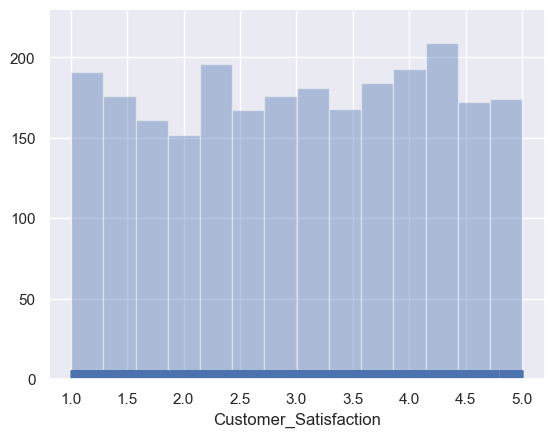

In [23]:
sns.distplot(df['Customer_Satisfaction'], kde=False, rug=True);

In [26]:
db = SQLDatabase(dbengine)

In [27]:
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True, return_direct=False)

In [28]:
def chat_with_db(user_query: str):
    """
    Function to take a user query and return answers from the sales_data table.
    Uses LangChain's SQLDatabaseChain to generate and execute SQL queries.

    Args:
        user_query (str): The natural language query from the user.
    
    Returns:
        str: The response generated based on the SQL query.
    """
    try:
        response = db_chain.run(user_query)
        return response
    except Exception as e:
        return f" Error processing query: {e}"

In [29]:
user_query='Give me teh average customer satisfcation for Widget D?'

In [30]:
response = chat_with_db(user_query)

C:\Users\jimmy\AppData\Local\Temp\ipykernel_24604\212915717.py:13: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = db_chain.run(user_query)




> Entering new SQLDatabaseChain chain...
Give me teh average customer satisfcation for Widget D?
SQLQuery:SELECT AVG(`Customer_Satisfaction`) AS Avg_Customer_Satisfaction
FROM sales_data
WHERE `Product` = 'Widget D';
SQLResult: [(Decimal('3.070305675915'),)]
Answer:The average customer satisfaction for Widget D is 3.07.
> Finished chain.


In [31]:
response

'The average customer satisfaction for Widget D is 3.07.'

In [42]:
user_query='Tell me teh average customer satisfcation for each product?'

In [43]:
response = chat_with_db(user_query)



> Entering new SQLDatabaseChain chain...
Tell me teh average customer satisfcation for each product?
SQLQuery:SELECT `Product`, AVG(`Customer_Satisfaction`) AS Avg_Customer_Satisfaction
FROM sales_data
GROUP BY `Product`;
SQLResult: [('Widget C', Decimal('3.007633180677')), ('Widget D', Decimal('3.070305675915')), ('Widget A', Decimal('3.031918429573')), ('Widget B', Decimal('2.993423630915'))]
Answer:The average customer satisfaction for each product is as follows:
- Widget C: 3.0076
- Widget D: 3.0703
- Widget A: 3.0319
> Finished chain.


In [44]:
response

'The average customer satisfaction for each product is as follows:\n- Widget C: 3.0076\n- Widget D: 3.0703\n- Widget A: 3.0319'

# Store PDF files as chunks in vector DB

In [45]:
class HuggingFaceEmbeddings:
    """Custom wrapper for Hugging Face SentenceTransformer embeddings."""
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.embedding_model = SentenceTransformer(model_name)
    
    def embed_documents(self, texts):
        """Generate embeddings for a list of documents."""
        return self.embedding_model.encode(texts, convert_to_tensor=False).tolist()
    
    def embed_query(self, text):
        """Generate embedding for a single query."""
        return self.embedding_model.encode(text, convert_to_tensor=False).tolist()

In [46]:
chunk_size=500
chunk_overlap=50

In [122]:
pdf_folder = "C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\PDF Folder"

In [182]:
output_folder = "C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\highlightedpdf"

In [183]:
highlighted_pdf_path = os.path.join(output_folder, "highlighted_output.pdf")

In [49]:
db_path = "chroma_db"

In [50]:
if os.path.exists(db_path):
        print(f"[INFO] Deleting existing Chroma database at {db_path} to avoid conflicts.")
        shutil.rmtree(db_path, ignore_errors=True)

In [53]:
embeddings = HuggingFaceEmbeddings()

In [56]:
chroma_settings = Settings(persist_directory=db_path, anonymized_telemetry=False)

In [57]:
vector_db = Chroma(persist_directory=db_path, embedding_function=embeddings, client_settings=chroma_settings)

C:\Users\jimmy\AppData\Local\Temp\ipykernel_24604\1200157228.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(persist_directory=db_path, embedding_function=embeddings, client_settings=chroma_settings)


In [188]:
def extract_chunks_with_coordinates(pdf_path):
    """Extract chunks from the PDF along with their coordinates (bounding boxes) and file name."""
    doc = fitz.open(pdf_path)
    chunks_with_metadata = []

    # Extract the file name from the full path
    file_name = os.path.basename(pdf_path)

    for page_num in range(len(doc)):
        page = doc[page_num]
        page_text = page.get_text("blocks")
        full_text = " ".join(block[4] for block in page_text)

        splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        text_chunks = splitter.split_text(full_text)

        for chunk in text_chunks:
            coordinates = []
            search_results = page.search_for(chunk)
            for rect in search_results:
                coordinates.append((rect.x0, rect.y0, rect.x1, rect.y1))

            chunks_with_metadata.append({
                "text": chunk,
                "page": page_num,
                "coordinates": coordinates,
                "file_name": file_name  # Add file name to metadata
            })

    return chunks_with_metadata


In [189]:
pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

In [190]:
pdf_files

['C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\PDF Folder\\AI business model innovation.pdf',
 'C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\PDF Folder\\BI approaches.pdf',
 'C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\PDF Folder\\Time-Series-Data-Prediction-using-IoT-and-Machine-Le_2020_Procedia-Computer-.pdf',
 'C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\PDF Folder\\Walmarts sales data analysis.pdf']

In [191]:
text_chunks_with_metadata = []
for pdf_file in pdf_files:
    chunks = extract_chunks_with_coordinates(pdf_file)
    text_chunks_with_metadata.extend(chunks)

In [192]:
text_chunks_with_metadata[0]

{'text': 'Journal of Business Research 182 (2024) 114764\n Available online 14 June 2024\n0148-2963/© 2024 The Authors. Published by Elsevier Inc. This is an open access article under the CC BY-NC-ND license (http://creativecommons.org/licenses/by-\nnc-nd/4.0/).\n AI-driven business model innovation: A systematic review and \nresearch agenda \n Philip Jorzik a, Sascha P. Klein b, Dominik K. Kanbach a, Sascha Kraus c,d,* \n a HHL Leipzig Graduate School of Management, Jahnallee 59, 04109 Leipzig, Germany',
 'page': 0,
 'coordinates': [],
 'file_name': 'AI business model innovation.pdf'}

In [193]:
chunk_texts = [item["text"] for item in text_chunks_with_metadata]
metadata = [{"page": item["page"], "file_name": item["file_name"], "coordinates": json.dumps(item["coordinates"])} for item in text_chunks_with_metadata]

In [194]:
chunk_texts[0]

'Journal of Business Research 182 (2024) 114764\n Available online 14 June 2024\n0148-2963/© 2024 The Authors. Published by Elsevier Inc. This is an open access article under the CC BY-NC-ND license (http://creativecommons.org/licenses/by-\nnc-nd/4.0/).\n AI-driven business model innovation: A systematic review and \nresearch agenda \n Philip Jorzik a, Sascha P. Klein b, Dominik K. Kanbach a, Sascha Kraus c,d,* \n a HHL Leipzig Graduate School of Management, Jahnallee 59, 04109 Leipzig, Germany'

In [195]:
metadata[0]

{'page': 0,
 'file_name': 'AI business model innovation.pdf',
 'coordinates': '[]'}

In [196]:
vector_db.add_texts(chunk_texts, metadatas=metadata)

['5e626f36-e48b-42e2-ae03-41c167403d98',
 '6caaa08a-7f4e-4d7d-ba62-6050cdf5339e',
 'bc1e0fdf-7d64-4371-9b15-5cae4e24e603',
 'd6f0c1a4-c476-4c06-b349-815b18b4fc2f',
 '332312b1-3932-4f03-a418-6f184848f168',
 'dd4b617f-2124-4b88-bdc9-364f9a4fef06',
 'ef9ef6c8-98bb-48e2-9dca-c382d788fe44',
 'a0348465-1730-4f12-8bc4-63c35a1f2cd8',
 'f6310d8f-eff6-4b99-9a42-235f265ce0ee',
 '4430c28d-4866-4f54-9493-aba6f11b3c68',
 '838a214d-5d43-4462-8487-8173e36a2c24',
 'fef54d65-5b67-49ea-be9c-9bc0bfdc118d',
 'a40bd68b-1c7f-467c-8201-9b8ed859f77b',
 '7850d490-90e4-4143-9cbe-593287159ac1',
 '92ca52f7-910f-4f50-99e0-07d684709f63',
 '72ca8039-879f-4c90-8f0d-ebcf8b80bc74',
 '7dcf1962-0425-41f1-9447-d5561015117d',
 '10d630fb-eb25-4a13-9e6b-e6bd91690a71',
 'af7e91ec-5f8c-4fad-80c0-bf8cd756bd80',
 '48b682c7-c004-4e53-9fb1-d7f65f4802eb',
 '40a66d3f-c77a-4678-83e0-c25e528b170b',
 'c5157cf3-8d9e-4fe1-9b6c-8248c1ec4f58',
 'e5a43dea-47f2-4b8c-9f2f-a48452c956f8',
 'ef735c96-2367-4770-8149-c28cffc0a447',
 'd1903c27-ef18-

In [197]:
vector_db.persist()

# Chat with PDF Data

In [199]:
user_query = 'Who introduced the term Business Intelligence, often referred to as BI?'

In [200]:
chat_history = [
    {"role": "user", "content": "CDC agrees to make the 504 Loan to the Borrower subject to what?"},
    {"role": "assistant", "content": "SBA's approval."},
    {"role": "user", "content": "Third Party Lender waives its rights for what?"},
    {"role": "assistant", "content": "Third Party Lender waives its rights to enforce provisions that do not comply with the 504 Loan Program Requirements."},
    {"role": "user", "content": "what does this document say about authority to execute agreement?"},
    {"role": "assistant", "content": "The persons signing below certify that they have been duly authorized to execute this Agreement on behalf of their respective party."}
]

In [202]:
# Template to rephrase the user query and extract metadata
template = """
Given the chat history and the current user query, rewrite the query so it forms a complete question, maintaining the context of the conversation. Then, extract metadata (only "file_name" and "page_number" fields) if they are mentioned in the question or chat history.
Rewritten query shoudl not have refernce to metadata fields file_name and page_number.

Chat History:
{chat_history}

Current user query: {query}

Rewritten query:
[Provide the rewritten query here.]

Extracted Metadata (JSON format with only file_name and page_number fields):
[Provide the metadata here as a valid JSON object.]
"""

In [203]:
# Format the chat history into a string
formatted_chat_history = "\n".join([f'{entry["role"].capitalize()}: {entry["content"]}' for entry in chat_history])

In [204]:
# Create the prompt for the LLM
prompt = PromptTemplate.from_template(template).format(
    chat_history=formatted_chat_history,
    query=user_query
)

In [205]:
prompt

'\nGiven the chat history and the current user query, rewrite the query so it forms a complete question, maintaining the context of the conversation. Then, extract metadata (only "file_name" and "page_number" fields) if they are mentioned in the question or chat history.\nRewritten query shoudl not have refernce to metadata fields file_name and page_number.\n\nChat History:\nUser: CDC agrees to make the 504 Loan to the Borrower subject to what?\nAssistant: SBA\'s approval.\nUser: Third Party Lender waives its rights for what?\nAssistant: Third Party Lender waives its rights to enforce provisions that do not comply with the 504 Loan Program Requirements.\nUser: what does this document say about authority to execute agreement?\nAssistant: The persons signing below certify that they have been duly authorized to execute this Agreement on behalf of their respective party.\n\nCurrent user query: Who introduced the term Business Intelligence, often referred to as BI?\n\nRewritten query:\n[Pro

In [206]:
# Get the response from the LLM
rewritten_query = llm(prompt)

In [207]:
rewritten_query

AIMessage(content='Rewritten query: \nWho is credited with introducing the term Business Intelligence, often referred to as BI?\n\nExtracted Metadata:\n{\n  "file_name": "N/A",\n  "page_number": "N/A"\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 240, 'total_tokens': 286, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-89f29044-55f6-4204-bc0f-ccc0e5e89372-0', usage_metadata={'input_tokens': 240, 'output_tokens': 46, 'total_tokens': 286, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [208]:
query = rewritten_query.content

In [209]:
query

'Rewritten query: \nWho is credited with introducing the term Business Intelligence, often referred to as BI?\n\nExtracted Metadata:\n{\n  "file_name": "N/A",\n  "page_number": "N/A"\n}'

In [210]:
top_chunks_with_scores = vector_db.similarity_search_with_score(query, k=3)

In [211]:
top_chunks_with_scores

[(Document(metadata={'coordinates': '[[64.80006408691406, 475.8836669921875, 216.0312042236328, 491.89166259765625], [64.80006408691406, 489.68365478515625, 67.80006408691406, 505.691650390625], [64.80006408691406, 503.483642578125, 67.80006408691406, 519.4916381835938], [64.80000305175781, 517.3648681640625, 209.7991485595703, 536.7271118164062], [64.80000305175781, 533.364013671875, 565.343994140625, 549.3720092773438], [64.800048828125, 547.1640014648438, 565.35009765625, 563.1719970703125], [64.800048828125, 560.9639892578125, 107.82485961914062, 576.9719848632812], [110.82366180419922, 560.9639892578125, 149.81646728515625, 576.9719848632812], [152.8152618408203, 560.9639892578125, 167.8224639892578, 576.9719848632812], [170.82125854492188, 560.9639892578125, 199.84326171875, 576.9719848632812], [202.84205627441406, 560.9639892578125, 255.1860809326172, 576.9719848632812], [258.18487548828125, 560.9639892578125, 326.5068664550781, 576.9719848632812], [329.50567626953125, 560.96398

In [212]:
# Extract chunk texts for cross-encoding
top_chunks = [chunk.page_content for chunk, _ in top_chunks_with_scores]

In [213]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

In [214]:
query_chunk_pairs = [(query, chunk) for chunk in top_chunks]

In [215]:
query_chunk_pairs

[('Rewritten query: \nWho is credited with introducing the term Business Intelligence, often referred to as BI?\n\nExtracted Metadata:\n{\n  "file_name": "N/A",\n  "page_number": "N/A"\n}',
  'supporting shared information. \n \n \n2.  Business Intelligence \nBusiness Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard \nDresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business \ndecision making by using fact-based computerized support systems (Nylund, 1999). The term is \nsometimes used interchangeably with briefing books and executive information systems. A business'),
 ('Rewritten query: \nWho is credited with introducing the term Business Intelligence, often referred to as BI?\n\nExtracted Metadata:\n{\n  "file_name": "N/A",\n  "page_number": "N/A"\n}',
  'supporting shared information. \n \n \n2.  Business Intelligence \nBusiness Intelligence, often referred to as BI, is a popularized, umbrella term i

In [216]:
cross_encoded_scores = cross_encoder.predict(query_chunk_pairs)

In [217]:
# Pair chunks with their cross-encoder scores and sort them in descending order
ranked_chunks_with_scores = sorted(
    zip(top_chunks_with_scores, cross_encoded_scores),
    key=lambda x: x[1],  # Sort by score (descending)
    reverse=True
)

In [218]:
top_chunk_cross_encoded, top_cross_encoded_score = ranked_chunks_with_scores[0][0]

In [219]:
metadata_of_top_chunk = top_chunk_cross_encoded.metadata

In [220]:
top_chunk_cross_encoded

Document(metadata={'coordinates': '[[64.80006408691406, 475.8836669921875, 216.0312042236328, 491.89166259765625], [64.80006408691406, 489.68365478515625, 67.80006408691406, 505.691650390625], [64.80006408691406, 503.483642578125, 67.80006408691406, 519.4916381835938], [64.80000305175781, 517.3648681640625, 209.7991485595703, 536.7271118164062], [64.80000305175781, 533.364013671875, 565.343994140625, 549.3720092773438], [64.800048828125, 547.1640014648438, 565.35009765625, 563.1719970703125], [64.800048828125, 560.9639892578125, 107.82485961914062, 576.9719848632812], [110.82366180419922, 560.9639892578125, 149.81646728515625, 576.9719848632812], [152.8152618408203, 560.9639892578125, 167.8224639892578, 576.9719848632812], [170.82125854492188, 560.9639892578125, 199.84326171875, 576.9719848632812], [202.84205627441406, 560.9639892578125, 255.1860809326172, 576.9719848632812], [258.18487548828125, 560.9639892578125, 326.5068664550781, 576.9719848632812], [329.50567626953125, 560.9639892

In [221]:
metadata_of_top_chunk

{'coordinates': '[[64.80006408691406, 475.8836669921875, 216.0312042236328, 491.89166259765625], [64.80006408691406, 489.68365478515625, 67.80006408691406, 505.691650390625], [64.80006408691406, 503.483642578125, 67.80006408691406, 519.4916381835938], [64.80000305175781, 517.3648681640625, 209.7991485595703, 536.7271118164062], [64.80000305175781, 533.364013671875, 565.343994140625, 549.3720092773438], [64.800048828125, 547.1640014648438, 565.35009765625, 563.1719970703125], [64.800048828125, 560.9639892578125, 107.82485961914062, 576.9719848632812], [110.82366180419922, 560.9639892578125, 149.81646728515625, 576.9719848632812], [152.8152618408203, 560.9639892578125, 167.8224639892578, 576.9719848632812], [170.82125854492188, 560.9639892578125, 199.84326171875, 576.9719848632812], [202.84205627441406, 560.9639892578125, 255.1860809326172, 576.9719848632812], [258.18487548828125, 560.9639892578125, 326.5068664550781, 576.9719848632812], [329.50567626953125, 560.9639892578125, 368.530883

In [222]:
llm_instruction = "Please answer the question by carefully considering both the provided context and the chat history. Use the context for accurate information and take into account any relevant details from the chat history to generate a well-informed response. If enough information is not available, please respond by saying: 'There is not enough information to answer the question.'"

In [223]:
# Create the prompt
template = """
Context: 
{context}

Chat history:
{chat_history}

Instruction: 
{llm_instruction}

User question: {question}
"""

In [224]:
formatted_prompt = PromptTemplate.from_template(template).format(
    context=top_chunk_cross_encoded.page_content,
    chat_history="\n".join([f'{entry["role"].capitalize()}: {entry["content"]}' for entry in chat_history]),
    question=query,
    llm_instruction=llm_instruction
)

In [225]:
formatted_prompt

'\nContext: \nsupporting shared information. \n \n \n2.  Business Intelligence \nBusiness Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard \nDresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business \ndecision making by using fact-based computerized support systems (Nylund, 1999). The term is \nsometimes used interchangeably with briefing books and executive information systems. A business\n\nChat history:\nUser: CDC agrees to make the 504 Loan to the Borrower subject to what?\nAssistant: SBA\'s approval.\nUser: Third Party Lender waives its rights for what?\nAssistant: Third Party Lender waives its rights to enforce provisions that do not comply with the 504 Loan Program Requirements.\nUser: what does this document say about authority to execute agreement?\nAssistant: The persons signing below certify that they have been duly authorized to execute this Agreement on behalf of their respective party.\n\n

In [226]:
# Get response from LLM
llm_response = llm.predict(formatted_prompt)

In [227]:
print("#"*50)
print(llm_response)

##################################################
Howard Dresner of the Gartner Group is credited with introducing the term Business Intelligence (BI).


# Traceback the answer to the original PDF document

In [228]:
# Configurable cosine similarity threshold
COSINE_SIMILARITY_THRESHOLD = 0.3

In [229]:
page_num =  metadata_of_top_chunk["page_number"]

In [230]:
page_num

1

In [231]:
coordinates_str = metadata_of_top_chunk["coordinates"]

In [232]:
coordinates_str

'[[64.80006408691406, 475.8836669921875, 216.0312042236328, 491.89166259765625], [64.80006408691406, 489.68365478515625, 67.80006408691406, 505.691650390625], [64.80006408691406, 503.483642578125, 67.80006408691406, 519.4916381835938], [64.80000305175781, 517.3648681640625, 209.7991485595703, 536.7271118164062], [64.80000305175781, 533.364013671875, 565.343994140625, 549.3720092773438], [64.800048828125, 547.1640014648438, 565.35009765625, 563.1719970703125], [64.800048828125, 560.9639892578125, 107.82485961914062, 576.9719848632812], [110.82366180419922, 560.9639892578125, 149.81646728515625, 576.9719848632812], [152.8152618408203, 560.9639892578125, 167.8224639892578, 576.9719848632812], [170.82125854492188, 560.9639892578125, 199.84326171875, 576.9719848632812], [202.84205627441406, 560.9639892578125, 255.1860809326172, 576.9719848632812], [258.18487548828125, 560.9639892578125, 326.5068664550781, 576.9719848632812], [329.50567626953125, 560.9639892578125, 368.5308837890625, 576.971

In [233]:
coordinates = json.loads(coordinates_str)

In [234]:
file_for_highlighting = os.path.join(pdf_folder, metadata_of_top_chunk['file_name'])

In [235]:
file_for_highlighting

'C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\PDF Folder\\BI approaches.pdf'

In [236]:
doc = fitz.open(file_for_highlighting)

In [237]:
page = doc.load_page(page_num)

In [238]:
chunk_text = " ".join(page.get_textbox(fitz.Rect(*coord)) for coord in coordinates)

In [239]:
chunk_text

'focus on tools supporting busin\nsupporting shared information. \n  s\n \n   \n \n2  \n2.  Business Intelligence \nBusiness Intelligence, often re 2.  Business Intelligence \nBusiness Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard \nDresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business  Business Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard \nDresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business \ndecision making by using fact-based computerized support systems (Nylund, 1999). The term is  Dresner o\ndecision \nsometime of the Ga\nmaking \nes used i artne\nby \nnter er Grou\nusing \nchange up in 1989 \nfact-based \neably with b to describe a se\ncomputerized \nbriefing books  et of con\nsupport \nand exec cepts and\nsystems \ncutive inf d methods \n(Nylund, \normation  to impr\n1999). \nsystems ove b\nThe \

In [240]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [164]:
sentences = nltk.sent_tokenize(chunk_text)

In [165]:
# Initialize Sentence Transformer for cosine similarity
similarity_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [166]:
# Compute embeddings for the LLM response and sentences
llm_response_embedding = similarity_model.encode(llm_response, convert_to_tensor=True)
sentence_embeddings = similarity_model.encode(sentences, convert_to_tensor=True)

In [167]:
# Compute cosine similarities
similarities = util.cos_sim(llm_response_embedding, sentence_embeddings)[0].tolist()

In [168]:
# Pair sentences with their similarity scores
sentences_with_scores = list(zip(sentences, similarities))

In [169]:
# Sort sentences by similarity score in descending order
sorted_sentences_with_scores = sorted(sentences_with_scores, key=lambda x: x[1], reverse=True)

In [170]:
for sentence, score in sorted_sentences_with_scores:
    print(f"Score: {score:.4f}, Sentence: {sentence}")
    print("#"*20)

Score: 0.8908, Sentence: s
 
   
 
2  
2.  Business Intelligence 
Business Intelligence, often re 2.  Business Intelligence 
Business Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard 
Dresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business  Business Intelligence, often referred to as BI, is a popularized, umbrella term introduced by Howard 
Dresner of the Gartner Group in 1989 to describe a set of concepts and methods to improve business 
decision making by using fact-based computerized support systems (Nylund, 1999).
####################
Score: 0.4717, Sentence: A business
intelligence system is a data-driven DSS that primarily supports querying of an historical database and
####################
Score: 0.4549, Sentence: The term is  Dresner o
decision 
sometime of the Ga
making 
es used i artne
by 
nter er Grou
using 
change up in 1989 
fact-based 
eably with b to describe a se
computerized 
briefing

In [171]:
# Find high-similarity sentences and their coordinates
high_similarity_sentences = []
for sentence, score in sorted_sentences_with_scores:
    if score >= COSINE_SIMILARITY_THRESHOLD:
        search_results = page.search_for(sentence)
        if search_results:  # Ensure search_results is not empty
            high_similarity_sentences.append(fitz.Rect(*search_results[0]))

In [241]:
high_similarity_sentences

[Rect(508.439208984375, 574.7640380859375, 565.3251342773438, 590.7720336914062),
 Rect(501.54736328125, 560.9639892578125, 523.2181396484375, 576.9719848632812)]

In [242]:
# Highlight the entire chunk in yellow
for coord in coordinates:
    rect = fitz.Rect(*coord)
    page.add_highlight_annot(rect)

In [243]:
highlighted_pdf_path

'C:\\gitworkspace\\aimldemo\\jupyterworkapce\\genai course\\capstoneproject\\Datasets\\highlightedpdf\\highlighted_output.pdf'

In [244]:
# Highlight high-similarity sentences in green
for rect in high_similarity_sentences:
    highlight = page.add_highlight_annot(rect)
    highlight.set_colors(stroke=(0, 1, 0))  # Green color
    highlight.update()

In [246]:
doc.save(highlighted_pdf_path, garbage=4)
doc.close()

# Router agent to dynamically route the user query to DB or PDF documents

In [296]:
SYSTEM_PROMPT = """
You are an AI assistant responsible for routing user queries correctly. 

### Database Description:
The database contains **structured sales data** with the following fields:
- **Date** (When the sale occurred)
- **Product** (e.g., Widget D)
- **Region** (e.g., East, North, South)
- **Sales** (Total sales count)
- **Customer_Age** (Age of the customer)
- **Customer_Gender** (Male/Female)
- **Customer_Satisfaction** (Numeric satisfaction score)

### Routing Criteria:
- If the user's query **relates to any of these fields**, respond **'USE_DB'**.
- If the user's query **does NOT relate to these fields and might require external document search**, respond **'USE_VECTOR'**.

### Example Responses:
- Query: "What is the total sales for Widget D in the South region?" → Response: **USE_DB**
- Query: "Summarize the latest credit review report." → Response: **USE_VECTOR**
- Query: "What is the financial outlook for Q1 2024?" → Response: **USE_VECTOR**
- Query: "Find the average customer satisfaction for Widget D?" → Response: **USE_DB**

ONLY return **USE_DB** or **USE_VECTOR** in your response.
"""

In [297]:
# Step 5: Define LLM-Based Query Classification
def classify_query(user_query: str):
    """
    Uses the LLM to determine if the user query is related to database data or vector search.
    
    Returns:
        str: "USE_DB" if the query should be routed to the database, "USE_VECTOR" otherwise.
    """
    prompt = f"{SYSTEM_PROMPT}\nUser Query: {user_query}\nAI Decision:"
    
    try:
        response = llm.predict(prompt).strip()
        print(f" LLM Routing Decision: {response}")
        return response
    except Exception as e:
        print(f" Error classifying query: {e}")
        return "USE_VECTOR"  # Default to vector search if classification fails

In [372]:
def chat_with_db(user_query: str):
    """
    Queries the MySQL database using LangChain's SQLDatabaseChain.

    Args:
        user_query (str): User's natural language query.

    Returns:
        str: The response generated from the SQL query.
    """
    try:
        response = db_chain.run(user_query)
        return response
    except Exception as e:
        return f"Error processing DB query: {e}"

In [373]:
def retrieve_pdf_chunk_and_llm_response(user_query: str):
    """
    Queries the vector database, retrieves the best-matching chunk, and uses LLM to generate a response.

    Args:
        user_query (str): User's natural language query.

    Returns:
        str: The response generated based on the retrieved PDF chunk.
    """
    try:
        top_chunks_with_scores = vector_db.similarity_search_with_score(user_query, k=3)
        retrieved_chunk = top_chunks_with_scores[0][0].page_content  
        print("******")
        print(retrieved_chunk)
        print("******")
        
        # Pass the retrieved text chunk to the LLM for final response generation
        llm_response = llm(user_query + " " + retrieved_chunk)
        print("****** llm_response")
        print(llm_response)
        print("******")
        
        return llm_response
    except Exception as e:
        return f" Error processing vector DB query: {e}"

In [374]:
query_database_tool = Tool(
    name="Database Query Tool",
    func=chat_with_db,
    description="Use this tool to answer questions about structured sales data in MySQL."
)

In [375]:
query_vector_db_tool = Tool(
    name="Vector Database Query Tool",
    func=retrieve_pdf_chunk_and_llm_response,
    description="Use this tool to answer questions about document data stored in the vector database."
)

In [376]:
def query_chatbot(user_query: str):
    """
    Routes the user query dynamically based on LLM classification.

    Args:
        user_query (str): User's natural language query.

    Returns:
        str: The chatbot's response from the appropriate tool.
    """
    routing_decision = classify_query(user_query)

    try:
        if routing_decision == "USE_DB":
            response = query_database_tool.run(user_query)
        else:
            response = query_vector_db_tool.run(user_query)
        
        return response
    except Exception as e:
        return f" Error processing query: {e}"

In [377]:
user_query_1 = "What is the total sales for Widget A in the South region?"

In [378]:
response_1 = query_chatbot(user_query_1)

 LLM Routing Decision: USE_DB


> Entering new SQLDatabaseChain chain...
What is the total sales for Widget A in the South region?
SQLQuery:SELECT SUM(`Sales`) AS TotalSales
FROM sales_data
WHERE `Product` = 'Widget A'
AND `Region` = 'South';
SQLResult: [(Decimal('99603'),)]
Answer:The total sales for Widget A in the South region is $99,603.
> Finished chain.


In [379]:
response_1

'The total sales for Widget A in the South region is $99,603.'

In [363]:
#user_query_2 = 'Who introduced the term Business Intelligence, often referred to as BI?'
user_query_2 = 'Who is Howard Dresner?'

In [321]:
response_2 = query_chatbot(user_query_2)

 LLM Routing Decision: USE_VECTOR
******
M¨
antym¨
aki et al., 2020  
 P. Jorzik et al.
******
****** llm_response
content='Howard Dresner is a well-known business intelligence expert and author. He is often credited with popularizing the term "business intelligence" and has published several books on the subject. Dresner has also served as a research fellow at Gartner, where he focused on business intelligence and analytics. He is considered a thought leader in the field of business intelligence and analytics.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 37, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-3971dc77-85ce-48c8-86ba

In [322]:
response_2.content

'Howard Dresner is a well-known business intelligence expert and author. He is often credited with popularizing the term "business intelligence" and has published several books on the subject. Dresner has also served as a research fellow at Gartner, where he focused on business intelligence and analytics. He is considered a thought leader in the field of business intelligence and analytics.'

# Generate SQL based on user query

In [422]:
allowed_tables = {
    "sales_data": ["id", "Date", "Product", "Region", "Sales", "Customer_Age", "Customer_Gender", "Customer_Satisfaction"],
    "orders": ["order_id", "customer_id", "order_date", "total_amount"],
    "products": ["product_id", "name", "category", "price"]
}

In [423]:
table_info = "\n".join(
    [f"Table: {table}\nColumns: {', '.join(columns)}" for table, columns in allowed_tables.items()]
)

In [424]:
table_info

'Table: sales_data\nColumns: id, Date, Product, Region, Sales, Customer_Age, Customer_Gender, Customer_Satisfaction\nTable: orders\nColumns: order_id, customer_id, order_date, total_amount\nTable: products\nColumns: product_id, name, category, price'

In [425]:
# Create a prompt for the LLM to generate SQL
prompt = f"""
You are an expert in SQL. Generate a SQL query based on the user's question.

### Database Schema:
{table_info}

### User Query:
{user_query_1}

### SQL Query:
"""

In [426]:
sql_query = llm.predict(prompt).strip()

In [427]:
sql_query

"SELECT SUM(Sales) AS Total_Sales\nFROM sales_data\nWHERE Product = 'Widget A' AND Region = 'South';"